In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torch.multiprocessing as mp

import os
import pickle

<br>

# Variables
---

## Path to dataset

In [3]:
PATH_PREPROCESSED = "/path/to/preprocessed/data/"

## GISMo related paths

In [4]:
GISMO_CODE_PATH = "/path/to/code/gismo/"
GISMO_PATH_PREPROCESSED = "/path/to/preprocessed/data/"
GISMO_OUTPUT_FOLDER = "/path/to/gismo/out"

<br>

# Loading the model
---

To load the model, you first have to export the model. To do so, use the command provided in the `README.md` (where `PATH_2` is the folder of the ImageToRecipe model that you trained):

    python visualize.py task=im2recipe \
        dataset.ablation.with_substitutions=True \
        name=eval_im2recipe_vit16_multi_level_recipe_inference \
        eval_checkpoint_dir=<<PATH_2>>

The resulting model will be output at the following location: `PATH_2/model_and_module.torch`. Use this path to load the model below:

In [5]:
PATH_TO_MODEL = "/path/to/model"


def load_model(path: str, device: str):
    cp = torch.load(path, map_location="cpu")
    model = cp["model"].to(device)
    model.eval()
    data_module = cp["data_module"]
    return model, data_module


model, data_module = load_model(path=PATH_TO_MODEL, device="cuda:0")

<br>

# Loading the ingredients
---

This step is not mandatory but allow you to see the list of ingredients that you can pick from, which might be useful later if you want to propose your own substitutions and see how the model reacts.

In [6]:
file_path = os.path.join(os.path.expanduser(PATH_PREPROCESSED), "final_recipe1m_vocab_ingrs.pkl")
with open(file_path, "rb") as f:
    vocab = pickle.load(f)
    
    
def pick_random_ingr(vocab):
    n = len(vocab.idx2word)
    idx = np.random.randint(n - 2) + 1
    return vocab.idx2word[idx][0]


# Test the dataset load is working by picking a random ingredient
pick_random_ingr(vocab)

'heads_cauliflower'

<br>

# Creating the object for interactive visualisation
---

In [7]:
from inv_cooking.utils.visualisation.im2recipe_viz import InteractiveSubstitutions

interactive_subs = InteractiveSubstitutions(
    model=model,
    data_module=data_module,
    use_pred_ingr=True,
    gismo_code_path=GISMO_CODE_PATH,
    gismo_preprocess_folder=GISMO_PATH_PREPROCESSED,
    gismo_output_folder=GISMO_OUTPUT_FOLDER,
)

<br>

# Interactive visualisation
---

## Visualise a recipe without substitutions

GROUND TRUTH RECIPE:
- all_purpose_flour
- baking_powder
- beer
- brown_sugar
- salt
- whole_wheat_flour
wheat beer bread
 -  preheat oven to 350 degrees f ( 175 degrees c ).
 -  lightly grease a 9x5 inch loaf pan.
 -  in a large mixing bowl, combine all-purpose flour, whole wheat flour, baking powder, salt and brown sugar.
 -  pour in beer, stir until a stiff batter is formed.
 -  it may be necessary to mix dough with your hands.
 -  scrape dough into prepared loaf pan.
 -  bake in preheated oven for 50 to 60 minutes, until a toothpick inserted into center of the loaf comes out clean.
GENERATED RECIPE:
- all_purpose_flour
- baking_powder
- beer
- brown_sugar
- salt
- whole_wheat_flour
beer bread
 -  preheat oven to 350 degrees.
 -  grease and flour a loaf pan.
 -  in a large bowl, combine the flours, baking powder, and salt.
 -  stir in the beer and brown sugar.
 -  pour into prepared loaf pan.
 -  bake for 1 hour.
 -  cool in pan for 10 minutes before removing to wire rack to cool co

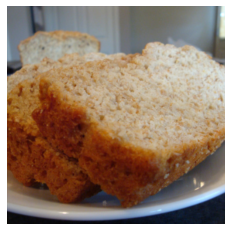

In [8]:
RECIPE_ID = "39818ba0d7" # '38d1d90c4d'

interactive_subs.use_pred_ingr = False
interactive_subs.sample_recipe(RECIPE_ID)
interactive_subs.use_pred_ingr = True

## Ask for substitutions on chosen ingredients

In [9]:
interactive_subs.compute_substitution("beer")  # Using GISMO

/checkpoint/adrianars/gismo_files/val_comments_subs.pkl
/checkpoint/adrianars/gismo_files/test_comments_subs.pkl


['apricot_preserve', '6_inch_corn_tortilla', 'peach_preserve']

## Choose the ingredient and generate recipe

INGREDIENTS:
- all_purpose_flour
- baking_powder
- brown_sugar
- salt
- water
- whole_wheat_flour
RECIPE:
whole wheat bread
 -  combine flours, baking powder, and salt.
 -  add brown sugar and mix well.
 -  add water and mix well.
 -  pour into a greased loaf pan.
 -  bake at 350 degrees for 1 hour.


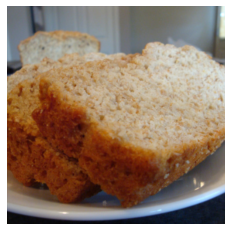

In [10]:
interactive_subs.substitute('beer', 'water')